In [1]:
import torch
from torch import nn

from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.nn import functional as F

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print (device)

cuda


In [3]:
mnist_img_size = (28,28)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = MNIST(root='train_mnist', train=True, download=True, transform=transform)
test_dataset  = MNIST(root='test_mnist', train=False, download=True, transform=transform)

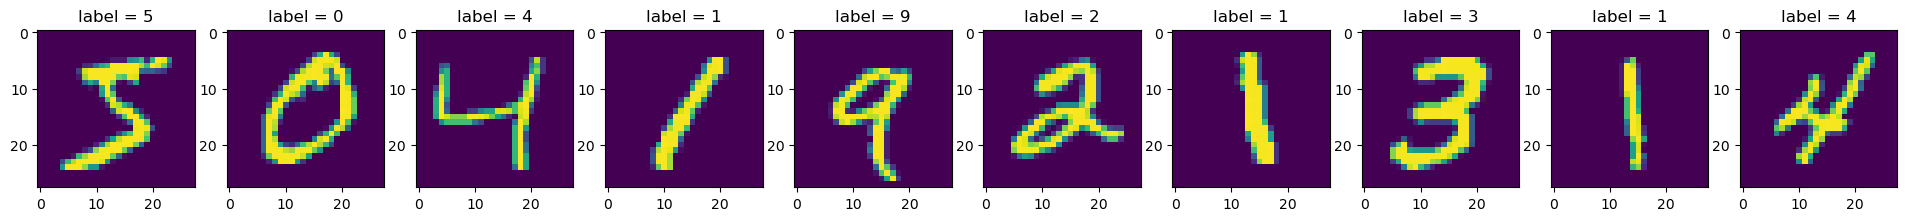

In [4]:
fig, ax = plt.subplots(1, 10, figsize=(24,4))
for i, axi in enumerate(ax):
  axi.imshow(train_dataset[i][0].numpy().reshape(mnist_img_size))
  axi.set_title('label = %i'%train_dataset[i][1])

In [5]:
class MLP(nn.Module):
    def __init__(self, input, layer1, layer2, output, dropout_p=0.25):
        super(MLP,self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input, layer1),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(layer1, layer2),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(layer2, output)
        )
    def forward(self,x):
        x = x.view(x.size(0), -1)
        x = self.layers(x)
        return x

In [6]:
model = MLP(28*28,256,64,10).to(device)
x = torch.randn(1,np.prod(mnist_img_size)).to(device)
print (model(x).shape)

torch.Size([1, 10])


In [7]:
criterion = nn.CrossEntropyLoss()
lr = 1e-3
# optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
batch_size = 256

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

num_epochs = 20
train_loss, test_loss = [], []
train_acc, test_acc = [], []
N_test = len(test_loader)

for epoch in tqdm(range(num_epochs)):

  epoch_loss = 0
  num_batches = 0
  correct_train = 0
  count_train = 0

  model.train()
  for x, y in train_loader:
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    z = model(x)
    loss = criterion(z,y)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.data
    num_batches += 1

    _, yhat_train = torch.max(z.data, 1)
    correct_train += (yhat_train == y).sum().item()
    count_train += y.size(0)

  train_loss.append(epoch_loss/num_batches)
  train_acc.append(correct_train/count_train)

  epoch_test_loss = 0
  num_test_batches = 0
  correct_test = 0
  count_test = 0

  model.eval()
  for x_test, y_test in test_loader:
    with torch.no_grad():
      x_test, y_test = x_test.to(device), y_test.to(device)
      z_test = model(x_test)
      loss_test = criterion(z_test, y_test)
      epoch_test_loss += loss_test.data
      num_test_batches += 1

      _, yhat_test = torch.max(z_test.data, 1)
      correct_test += (yhat_test == y_test).sum().item()
      count_test += y_test.size(0)

  test_loss.append(epoch_test_loss/num_test_batches)
  test_acc.append(correct_test/count_test)

  print ('Epoch %i, train acc = %.4f, test accuracy = %.4f, train loss = %.4f, test loss = %.4f'\
                %(epoch, train_acc[-1], test_acc[-1], train_loss[-1], test_loss[-1]))

  5%|▌         | 1/20 [00:10<03:11, 10.10s/it]

Epoch 0, train acc = 0.7752, test accuracy = 0.9228, train loss = 0.7181, test loss = 0.2558


 10%|█         | 2/20 [00:19<02:55,  9.76s/it]

Epoch 1, train acc = 0.9053, test accuracy = 0.9420, train loss = 0.3330, test loss = 0.1830


 15%|█▌        | 3/20 [00:29<02:43,  9.61s/it]

Epoch 2, train acc = 0.9266, test accuracy = 0.9538, train loss = 0.2544, test loss = 0.1432


 20%|██        | 4/20 [00:38<02:32,  9.54s/it]

Epoch 3, train acc = 0.9380, test accuracy = 0.9601, train loss = 0.2226, test loss = 0.1262


 25%|██▌       | 5/20 [00:47<02:22,  9.48s/it]

Epoch 4, train acc = 0.9457, test accuracy = 0.9645, train loss = 0.1919, test loss = 0.1142


 30%|███       | 6/20 [00:57<02:12,  9.45s/it]

Epoch 5, train acc = 0.9494, test accuracy = 0.9674, train loss = 0.1786, test loss = 0.1061


 35%|███▌      | 7/20 [01:06<02:02,  9.45s/it]

Epoch 6, train acc = 0.9536, test accuracy = 0.9702, train loss = 0.1638, test loss = 0.1025


 40%|████      | 8/20 [01:16<01:53,  9.44s/it]

Epoch 7, train acc = 0.9559, test accuracy = 0.9697, train loss = 0.1548, test loss = 0.0990


 45%|████▌     | 9/20 [01:25<01:43,  9.44s/it]

Epoch 8, train acc = 0.9583, test accuracy = 0.9712, train loss = 0.1455, test loss = 0.0918


 50%|█████     | 10/20 [01:35<01:34,  9.45s/it]

Epoch 9, train acc = 0.9607, test accuracy = 0.9733, train loss = 0.1393, test loss = 0.0867


 55%|█████▌    | 11/20 [01:44<01:24,  9.44s/it]

Epoch 10, train acc = 0.9624, test accuracy = 0.9733, train loss = 0.1321, test loss = 0.0853


 60%|██████    | 12/20 [01:53<01:15,  9.44s/it]

Epoch 11, train acc = 0.9618, test accuracy = 0.9748, train loss = 0.1307, test loss = 0.0853


 65%|██████▌   | 13/20 [02:03<01:06,  9.44s/it]

Epoch 12, train acc = 0.9648, test accuracy = 0.9743, train loss = 0.1216, test loss = 0.0867


 70%|███████   | 14/20 [02:12<00:56,  9.44s/it]

Epoch 13, train acc = 0.9660, test accuracy = 0.9755, train loss = 0.1188, test loss = 0.0836


 75%|███████▌  | 15/20 [02:22<00:47,  9.46s/it]

Epoch 14, train acc = 0.9656, test accuracy = 0.9734, train loss = 0.1164, test loss = 0.0862


 80%|████████  | 16/20 [02:31<00:37,  9.47s/it]

Epoch 15, train acc = 0.9667, test accuracy = 0.9737, train loss = 0.1152, test loss = 0.0873


 85%|████████▌ | 17/20 [02:41<00:28,  9.47s/it]

Epoch 16, train acc = 0.9687, test accuracy = 0.9764, train loss = 0.1075, test loss = 0.0799


 90%|█████████ | 18/20 [02:50<00:18,  9.46s/it]

Epoch 17, train acc = 0.9694, test accuracy = 0.9782, train loss = 0.1053, test loss = 0.0771


 95%|█████████▌| 19/20 [03:00<00:09,  9.46s/it]

Epoch 18, train acc = 0.9699, test accuracy = 0.9798, train loss = 0.1017, test loss = 0.0736


100%|██████████| 20/20 [03:09<00:00,  9.48s/it]

Epoch 19, train acc = 0.9701, test accuracy = 0.9767, train loss = 0.1016, test loss = 0.0848


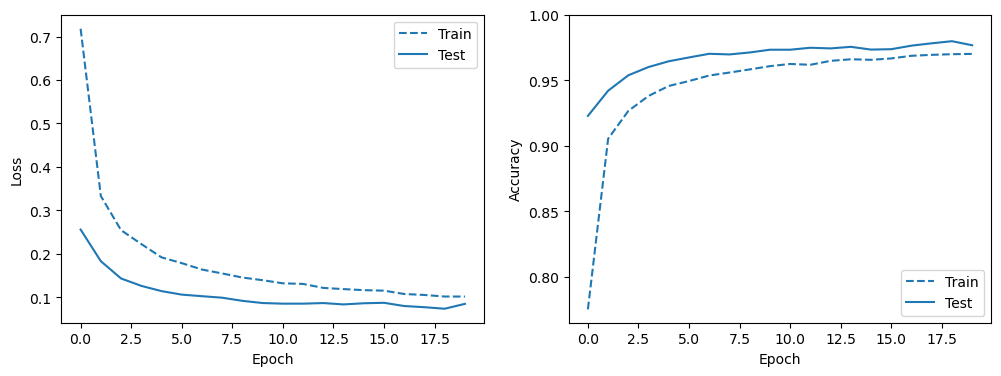

In [10]:
train_loss_cpu = [t.cpu().numpy() for t in train_loss]
test_loss_cpu = [t.cpu().numpy() for t in test_loss]

fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(train_loss_cpu, 'C0--', label ='Train')
ax[0].plot(test_loss_cpu, 'C0', label = 'Test')

ax[1].plot(train_acc, 'C0--', label ='Train')
ax[1].plot(test_acc, 'C0', label = 'Test')
ax[1].set_ylim(top=1)

ax[0].set_xlabel("Epoch")
ax[1].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[1].set_ylabel("Accuracy")
ax[0].legend(loc=0)
ax[1].legend(loc=0)

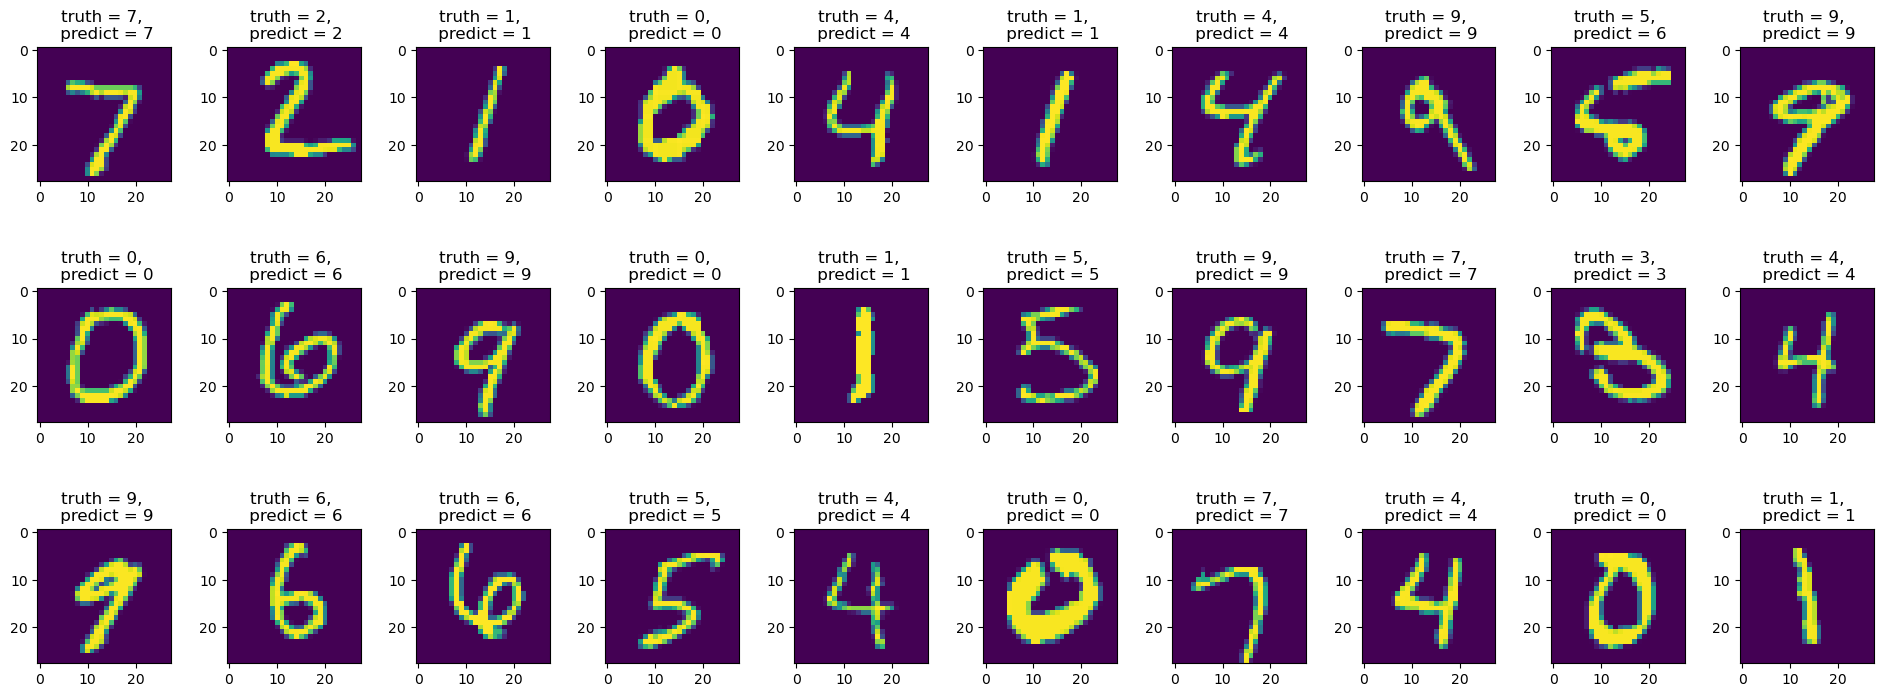

In [14]:
fig, ax = plt.subplots(3, 10, figsize=(24,8))
ax = ax.flatten()
for i, axi in enumerate(ax):
  axi.imshow(test_dataset[i][0].numpy().reshape(mnist_img_size))
  z_test = model(test_dataset[i][0].to(device))
  _, lbl_prediction = torch.max(z_test.data, 1)
  axi.set_title('truth = %i, \n predict = %i'%(test_dataset[i][1], lbl_prediction))
plt.subplots_adjust(hspace=0.8)

8
104
151
247
259
300
321
381
445
449


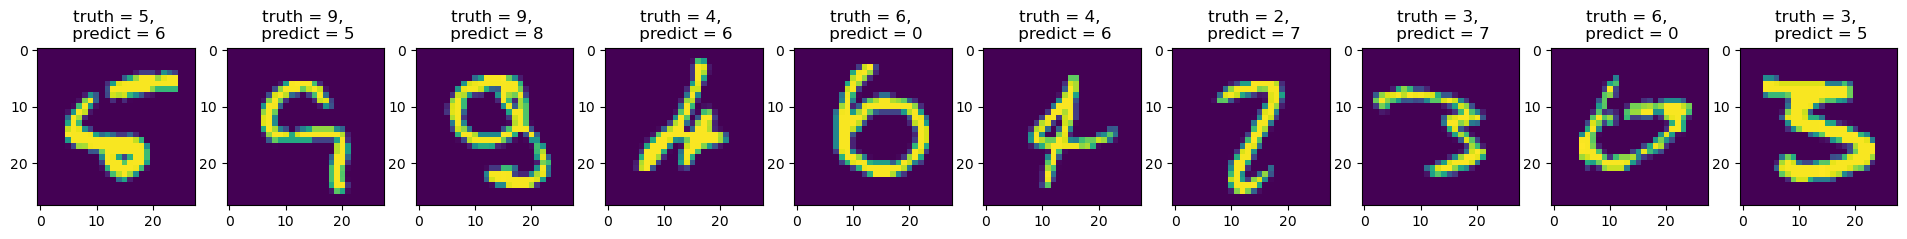

In [16]:
fig, ax = plt.subplots(1, 10, figsize=(24,8))
ax = ax.flatten()
failures = 0
i = 0
while failures < len(ax):
    z_test = model(test_dataset[i][0].to(device).unsqueeze(0))
    _, lbl_prediction = torch.max(z_test.data, 1)
    if lbl_prediction != test_dataset[i][1]:
        ax[failures].imshow(test_dataset[i][0].numpy().reshape(mnist_img_size))
        ax[failures].set_title('truth = %i, \n predict = %i'%(test_dataset[i][1], lbl_prediction))
        failures += 1
        print (i)
    i += 1
plt.subplots_adjust(hspace=0.8)

In [19]:
np.log(np.prod(mnist_img_size))

6.664409020350408